# Fine-tune des Mobilenet_V2
---

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

## Model einladen aus Keras
- Weights aus den Imagnet Dataset traniert
- Erwarteten Input 224,224, 3 

In [2]:
from keras.applications.mobilenet_v2 import MobileNetV2

# 1. Lade das vortrainierte MobileNetV2 Modell mit ImageNet-Gewichten
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=1000)


### Binary Classification

### Weights und Bais des Hauptmodel werden eingeforen damit sie sich nicht verändern

Zum Basis modell werden 3 Neue sichten hinzugefügt 
- GlobalAveragePooling2D
- Dense Layer
- Dense Layer mit Sigmoid für die Binäre Klassifikation

In [3]:
# 2. Friere die Basis (MobileNetV2) ein
base_model.trainable = False

# 3. Erstelle das neue Modell, indem du zusätzliche Schichten hinzufügst
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),        # Globales Pooling der Features
    layers.Dense(1024, activation='relu'),  # Neue Dense-Schicht
    layers.Dense(1, activation='sigmoid')   # Ausgabe-Schicht für binäre Klassifikation
])


In [4]:
# 4. Kompiliere das Modell (nur die hinzugefügten Schichten werden trainiert)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy', # binär
              metrics=['accuracy'])

In [5]:
# 5. Vorbereitung der Bilddaten (Beispiel: Lade Daten aus Verzeichnissen)
train_datagen = ImageDataGenerator(rescale=1.0/255.0,  # Normalisierung
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [6]:
train_dir = r'cats_and_dogs_small\train\100_pic'  # Dein Trainingsdaten-Verzeichnis
validation_dir = r'cats_and_dogs_small\validation/100_pic'  # Dein Validierungsdaten-Verzeichnis

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')



validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')



Found 202 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


In [27]:
import json
import os

# Überprüfen, ob das Modell bereits existiert
path_to_model = r"model/fine_tuned_model.keras"
if os.path.isfile(path_to_model):
    history = load_model(path_to_model)
    print("exist")
else:       
    # Trainiere das Modell
    history = model.fit(
        train_generator,
        epochs=8,
        validation_data=validation_generator,
        callbacks=[  # Optionale Callbacks (z.B. für das Speichern des besten Modells)
            keras.callbacks.ModelCheckpoint('model/fine_tuned_model.keras', save_best_only=True, monitor='val_loss')
        ]
    )
    
    # Speichern der Trainingshistorie als JSON-Datei
    history_dict = history.history  # Das History-Objekt enthält alle Metriken
    with open('train_history.json', 'w') as json_file:
        json.dump(history_dict, json_file, indent=4)



Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 875ms/step - accuracy: 0.9950 - loss: 0.0116 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 874ms/step - accuracy: 0.9988 - loss: 0.0039 - val_accuracy: 0.9950 - val_loss: 0.0053
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 900ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 896ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 6.9527e-04
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 844ms/step - accuracy: 0.9942 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 808ms/step - accuracy: 0.9946 - loss: 0.0152 - val_accuracy: 0.9950 - val_loss: 0.0109
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 817ms/step - accuracy: 0.9988 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 859ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0

In [28]:
# Evaluierung des Modells auf den Validierungsdaten
eval_results = model.evaluate(validation_generator)
print(f"Loss: {eval_results[0]}")
print(f"Accuracy: {eval_results[1]}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 1.0000 - loss: 0.0013
Loss: 0.0017846394330263138
Accuracy: 1.0


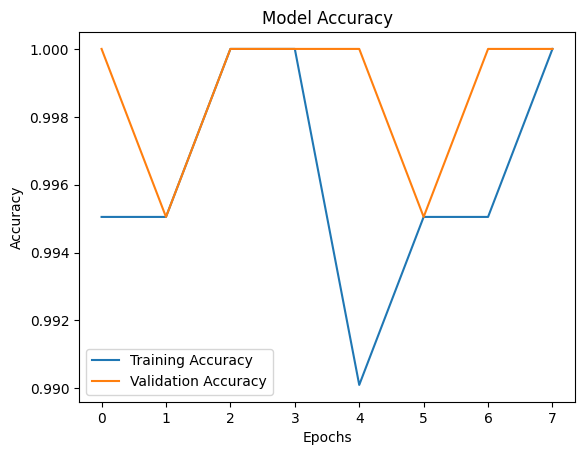

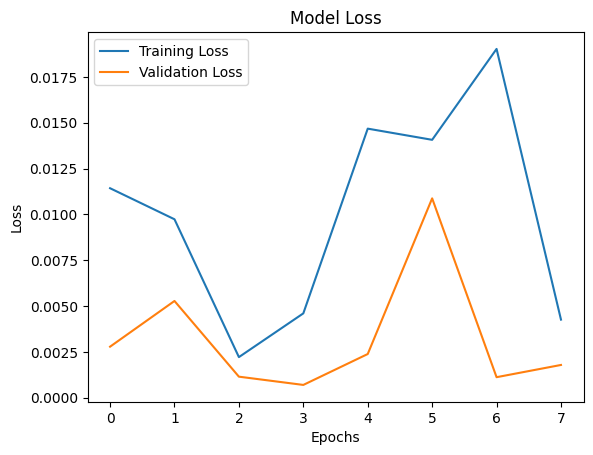

In [29]:
import json
import matplotlib.pyplot as plt

# Laden der JSON-Datei mit den Trainingsdaten
with open('train_history.json', 'r') as json_file:
    history_dict = json.load(json_file)

# Beispiel für das Plotten der Trainings- und Validierungsgenauigkeit
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Beispiel für das Plotten des Trainings- und Validierungsverlusts
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 1. Lade das Bild, das du testen möchtest
img_path = r'cats_and_dogs_small\train\dogs\1.jpg'  # Pfad zum Bild, das du testen möchtest

# Lade das Bild und skaliere es auf die Eingabegröße des Modells (z.B. 224x224 für MobileNetV2)
img = image.load_img(img_path, target_size=(224, 224))

# 2. Konvertiere das Bild in ein Array und normalisiere es (wie beim Training)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Füge eine Batch-Dimension hinzu
img_array /= 255.0  # Normalisiere das Bild (falls beim Training auch normalisiert wurde)

# 3. Vorhersage des Modells
predictions = model.predict(img_array)
print(predictions)
# # 4. Interpretiere die Vorhersage
# # Hier nehmen wir an, dass es sich um ein binäres Klassifikationsproblem handelt
# # (z.B. Hund vs. Katze)

# # Bei binärer Klassifikation gibt das Modell eine Wahrscheinlichkeit zurück
# # Wenn die Wahrscheinlichkeit größer als 0.5 ist, dann gehört das Bild zur positiven Klasse
# if predictions[0] > 0.5:
#     print("Das Bild zeigt die Hund Klasse.")
# else:
#     print("Das Bild zeigt die Katzen Klasse.")

# # 5. (Optional) Visualisiere das Bild
# plt.imshow(img)
# plt.title(f'Prediction: {"Positive" if predictions[0] > 0.5 else "Negative"}')
# plt.axis('off')  # Verstecke die Achsen
# #plt.text(x=0,y=0,s=str(predictions))
# plt.show()
# print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
[[0.9999779]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Das Bild zeigt die Hund Klasse.


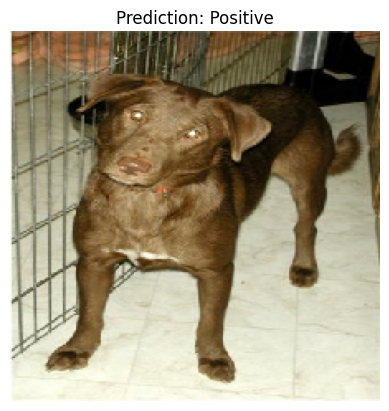

[[0.9999779]]


In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 1. Lade das Bild, das du testen möchtest
img_path = r'cats_and_dogs_small\train\dogs\1.jpg'  # Pfad zum Bild, das du testen möchtest

# Lade das Bild und skaliere es auf die Eingabegröße des Modells (z.B. 224x224 für MobileNetV2)
img = image.load_img(img_path, target_size=(224, 224))

# 2. Konvertiere das Bild in ein Array und normalisiere es (wie beim Training)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Füge eine Batch-Dimension hinzu
img_array /= 255.0  # Normalisiere das Bild (falls beim Training auch normalisiert wurde)

# 3. Vorhersage des Modells
predictions = model.predict(img_array)

# 4. Interpretiere die Vorhersage
# Hier nehmen wir an, dass es sich um ein binäres Klassifikationsproblem handelt
# (z.B. Hund vs. Katze)

# Bei binärer Klassifikation gibt das Modell eine Wahrscheinlichkeit zurück
# Wenn die Wahrscheinlichkeit größer als 0.5 ist, dann gehört das Bild zur positiven Klasse
if predictions[0] > 0.5:
    print("Das Bild zeigt die Hund Klasse.")
else:
    print("Das Bild zeigt die Katzen Klasse.")

# 5. (Optional) Visualisiere das Bild
plt.imshow(img)
plt.title(f'Prediction: {"Positive" if predictions[0] > 0.5 else "Negative"}')
plt.axis('off')  # Verstecke die Achsen
#plt.text(x=0,y=0,s=str(predictions))
plt.show()
print(predictions)

----

## Mehrere Klassifikationen erstellen:

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

# 1. Lade das vortrainierte MobileNetV2 Modell mit ImageNet-Gewichten
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=1000)


In [ ]:
# 2. Friere die Basis (MobileNetV2) ein
base_model.trainable = False

# 3. Erstelle das neue Modell, indem du zusätzliche Schichten hinzufügst
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),        # Globales Pooling der Features
    layers.Dense(1024, activation='relu'),  # Neue Dense-Schicht
    layers.Dense(1, activation='cate')   # Ausgabe-Schicht für binäre Klassifikation
])


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

# Modell laden
model_path = r"model\convnet_from_scratch.keras"
model = tf.keras.models.load_model(model_path)

# Modell kompilieren
model.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

# ImageDataGenerator für das Training und die Validierung erstellen
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normiere die Pixelwerte
    rotation_range=40,  # Beispiel: Rotation für mehr Variabilität
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Lade die Trainings- und Validierungsdaten aus den Verzeichnissen
train_dir = r"cats_and_dogs_small\train"
validation_dir = r"cats_and_dogs_small\validation"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),  # Beispiel für eine Zielgröße
    batch_size=32,
    class_mode='binary'  # Da du einen binären Klassifikator verwendest (z. B. Hund/Katze)
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

# Modell trainieren
callbacks = [
    ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks
)


In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")